Завдання 1. Реалізувати модель, яка зможе ідентифікувати художника.
Набір даних: Best Artworks of All Time
(https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time)

Бібліотеки, які знадобляться для роботи:

In [84]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import seaborn as sb
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
import os
from PIL import Image

Завантажити файл artists.csv. Подивитися перші 5 записів

In [2]:
df = pd.read_csv('artists.csv')

print(df.head(5))

   id                name        years                         genre   
0   0   Amedeo Modigliani  1884 - 1920                 Expressionism  \
1   1  Vasiliy Kandinskiy  1866 - 1944  Expressionism,Abstractionism   
2   2        Diego Rivera  1886 - 1957       Social Realism,Muralism   
3   3        Claude Monet  1840 - 1926                 Impressionism   
4   4       Rene Magritte  1898 - 1967      Surrealism,Impressionism   

  nationality                                                bio   
0     Italian  Amedeo Clemente Modigliani (Italian pronunciat...  \
1     Russian  Wassily Wassilyevich Kandinsky (Russian: Васи́...   
2     Mexican  Diego María de la Concepción Juan Nepomuceno E...   
3      French  Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...   
4     Belgian  René François Ghislain Magritte (French: [ʁəne...   

                                        wikipedia  paintings  
0  http://en.wikipedia.org/wiki/Amedeo_Modigliani        193  
1  http://en.wikipedia.org/wiki/

Зображення кожного художника розміщенні у папці з його ім'ям. 
Для того щоб сформувати список усіх класів, проведемо наступні операції з 
файловою системою:

In [3]:
images_path = 'images/images/'
class_names = os.listdir(images_path)
class_names.remove("Albrecht_Du¦Иrer")
class_names.remove("Albrecht_DuтХа+кrer")
class_names.sort()
print(class_names)

['Alfred_Sisley', 'Amedeo_Modigliani', 'Andrei_Rublev', 'Andy_Warhol', 'Camille_Pissarro', 'Caravaggio', 'Claude_Monet', 'Diego_Rivera', 'Diego_Velazquez', 'Edgar_Degas', 'Edouard_Manet', 'Edvard_Munch', 'El_Greco', 'Eugene_Delacroix', 'Francisco_Goya', 'Frida_Kahlo', 'Georges_Seurat', 'Giotto_di_Bondone', 'Gustav_Klimt', 'Gustave_Courbet', 'Henri_Matisse', 'Henri_Rousseau', 'Henri_de_Toulouse-Lautrec', 'Hieronymus_Bosch', 'Jackson_Pollock', 'Jan_van_Eyck', 'Joan_Miro', 'Kazimir_Malevich', 'Leonardo_da_Vinci', 'Marc_Chagall', 'Michelangelo', 'Mikhail_Vrubel', 'Pablo_Picasso', 'Paul_Cezanne', 'Paul_Gauguin', 'Paul_Klee', 'Peter_Paul_Rubens', 'Pierre-Auguste_Renoir', 'Piet_Mondrian', 'Pieter_Bruegel', 'Raphael', 'Rembrandt', 'Rene_Magritte', 'Salvador_Dali', 'Sandro_Botticelli', 'Titian', 'Vasiliy_Kandinskiy', 'Vincent_van_Gogh', 'William_Turner']


Далі сформуємо набір даних у вигляді: шлях до зображення, ім'я 
художника.

In [4]:
labels = []
images = []
for i in range(len(class_names)):
 label = np.zeros(len(class_names), dtype = np.float32)
 label[i] = 1
 
 class_image_path = images_path + class_names[i]
 image_files = os.listdir(class_image_path)
 image_files.sort()
 for image in image_files:
  file_path = os.path.join(class_image_path, image)
  images.append(file_path)
  labels.append(label)

Декодувати зображення у тензор uint8 і змінити розмір;

In [5]:
def load_image(filename):
 image_string = tf.io.read_file(filename)
 image = tf.image.decode_jpeg(image_string, channels = 3)
 image = tf.image.resize(image, (225, 225))
 
 return image

Завантажити та попередньо обробити зображення

In [6]:
batch_size = 64
image_size = (225, 225)
images_dataset = tf.data.Dataset.from_tensor_slices(images)
images_dataset = images_dataset.map(load_image)
# За допомогою tf.data.Dataset.from_tensor_slices()методу ми можемо отримати фрагменти масиву у вигляді об’єктів
labels_dataset = tf.data.Dataset.from_tensor_slices(labels)
#Замість поділу на два набори даних, один для зображень, а інший для міток, краще зробити один, який повертає і зображення, і мітку.
dataset = tf.data.Dataset.zip((images_dataset, labels_dataset))
dataset = dataset.shuffle(buffer_size = 1024)
dataset = dataset.shuffle(buffer_size = 1024)
dataset = dataset.batch(batch_size, drop_remainder = False)
total_batches = dataset.cardinality().numpy()
train_batches_count = round(total_batches * 0.8)
val_batches_count = (total_batches - train_batches_count) // 2
dataset = dataset.shuffle(buffer_size = 1024)
dataset = dataset.shuffle(buffer_size = 1024)
train_dataset = dataset.take(train_batches_count)
train_dataset = train_dataset.prefetch(4)
 
val_dataset = dataset.skip(train_batches_count).take(val_batches_count)
val_dataset = val_dataset.prefetch(4)
 
test_dataset = dataset.skip(train_batches_count + val_batches_count)
test_dataset = test_dataset.prefetch(4)

Виявити пошкоджені даних

Giotto di Bondone


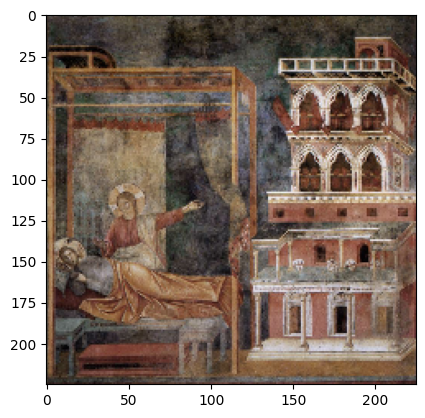

In [8]:
train_example = None
for batch in dataset.enumerate():
 train_example = batch
 break
_, data = train_example
batch_images = data[0]
batch_labels = data[1]
example_index = 10
artist_index = np.argmax(batch_labels[example_index])
print(class_names[artist_index].replace('_', ' '))
image = tf.keras.utils.array_to_img(batch_images[example_index])
plt.imshow(image)

 Реалізувати модель VGG19.

In [9]:
pretrained_model = tf.keras.applications.vgg19.VGG19(
 include_top = False,
 weights='imagenet',
 input_shape = (225, 225, 3),
 classes = len(class_names)
)

Для покращення ефективності навченої моделі, преренавчимо 
певні шари базової мережі VGG19, для цього виконаємо наступний фрагмент 
коду 

In [10]:
for layer in pretrained_model.layers:
 layer.trainable = False
 if layer.name == 'block5_conv3':
  break
 
pretrained_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 225, 225, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 225, 225, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 225, 225, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Sequential групує лінійний стек шарів у tf.keras.Model

In [11]:
augmentation_model = tf.keras.models.Sequential([
 tf.keras.layers.RandomFlip('horizontal'),
 tf.keras.layers.RandomRotation(0.1),
 tf.keras.layers.RandomZoom(0.1),
 tf.keras.layers.RandomTranslation(0.1, 0.1),
])
custom_model = tf.keras.models.Sequential([
 tf.keras.layers.Flatten(),
 tf.keras.layers.Dense(1024, activation='relu'),
 tf.keras.layers.BatchNormalization(),
 tf.keras.layers.Dense(256, activation='relu'),
 tf.keras.layers.Dropout(0.2),
 tf.keras.layers.Dense(len(class_names), activation='softmax'),
])

Створити екземпляр тензору

In [12]:
inputs = tf.keras.Input(shape = image_size + (3, ))
x = augmentation_model(inputs)
#Попередньо обробляємо тензор, що кодує пакет зображень.
x = tf.keras.applications.vgg19.preprocess_input(x)
x = pretrained_model(x)
outputs = custom_model(x)
#Модель, яка групує шари в об’єкт із функціями навчання/виведення
model = tf.keras.models.Model(inputs, outputs)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

Переглянути резюме моделі.

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 225, 225, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 225, 225, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 225, 225, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 225, 225, 3)      0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 sequential_1 (Sequential)   (None, 49)                25970225  
                                                             

Зупинити навчання, коли показник, що відстежується, перестане 
покращуватися.

In [14]:
epochs = 10
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True)
my_history = model.fit(train_dataset, epochs = epochs, validation_data = val_dataset, callbacks = [early_stopping_callback])

Epoch 1/10
102/102 [==============================] - 2980s 28s/step - loss: 2.7674 - accuracy: 0.3099 - val_loss: 3.6844 - val_accuracy: 0.3372
Epoch 2/10
102/102 [==============================] - 2955s 29s/step - loss: 1.9754 - accuracy: 0.4627 - val_loss: 5.0533 - val_accuracy: 0.3372
Epoch 3/10
102/102 [==============================] - 2704s 26s/step - loss: 1.6211 - accuracy: 0.5429 - val_loss: 1.8946 - val_accuracy: 0.5208
Epoch 4/10
102/102 [==============================] - 2669s 26s/step - loss: 1.4954 - accuracy: 0.5749 - val_loss: 3.8722 - val_accuracy: 0.3411
Epoch 5/10
102/102 [==============================] - 2636s 25s/step - loss: 1.4109 - accuracy: 0.5940 - val_loss: 2.7200 - val_accuracy: 0.4297
Epoch 6/10
102/102 [==============================] - 2750s 27s/step - loss: 1.1972 - accuracy: 0.6523 - val_loss: 1.3056 - val_accuracy: 0.6393
Epoch 7/10
102/102 [==============================] - 2648s 26s/step - loss: 1.0467 - accuracy: 0.6896 - val_loss: 1.3220 - val_ac

 Зберегти модель.

In [15]:
model.save('lab5_model.h5')

Побудувати графік історії навчання. Провести аналіз отриманих 
даних. 

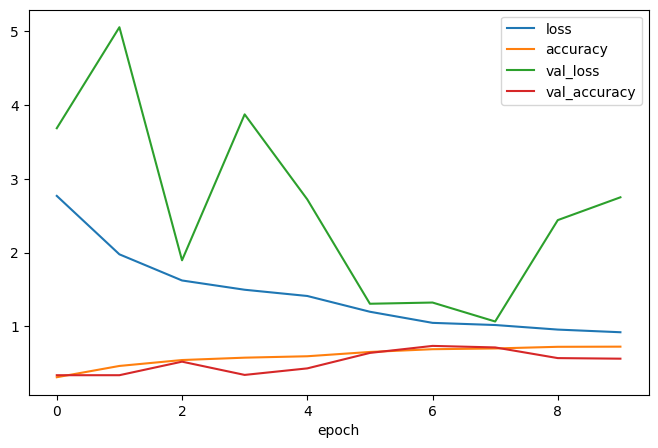

In [26]:
pd.DataFrame(my_history.history).plot(figsize=(8,5))
plt.xlabel('epoch')
plt.show()

Для побудування confusion matrix необхідно виконати визначення 
художників для картин та порівняти результати з очікуваним. Це 
мариця(таблиця), яка використовується в класифікаційних задачах, щоб 
оцінити, де були допущені помилки в моделі . Рядки представляють фактичні 
класи, якими мали бути результати. У той час як стовпці представляють 
прогнози, які ми зробили. За допомогою цієї таблиці легко побачити, які 
прогнози помилкові.

In [7]:
model = load_model('lab5_model.h5')
predicted_labels = []
actual_labels = []
for batch in test_dataset.enumerate():
    _, data = batch
    images, labels = data
    predictions = model.predict(images)
    for i in range (len(predictions)):
        predicted_labels.append(np.argmax(predictions[i]))
        actual_labels.append(np.argmax(labels[i]))
correct_predictions_count = 0
total_count = len(predicted_labels)
for i in range(len(predicted_labels)):
    if (predicted_labels[i] == actual_labels[i]):
        correct_predictions_count += 1
print('Точність:', str(round(correct_predictions_count / total_count * 100, 2)) + "%")

2/2 [==============================] - 19s 10s/step
Точність: 59.13%


Побудування confusion matrix 

<Axes: >

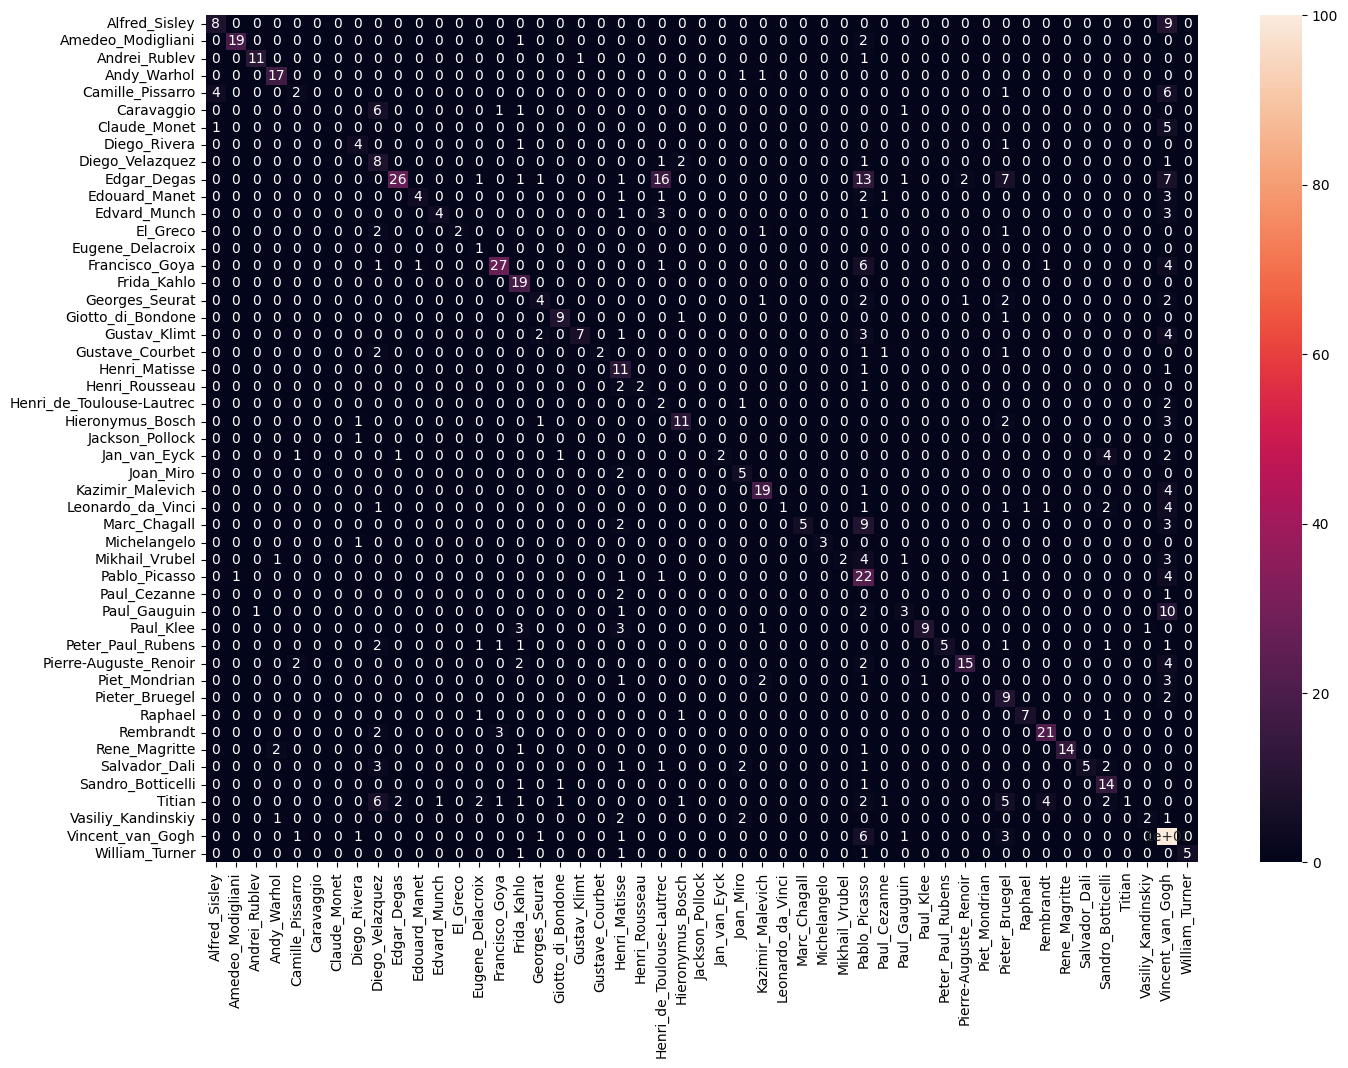

In [28]:
cm = confusion_matrix(actual_labels, predicted_labels)
plt.figure(figsize = (16,11))
sb.heatmap(cm, annot = True, xticklabels = class_names, yticklabels = class_names)

Провести тестування отриманої моделі.

Predicted: Amedeo Modigliani
Actual: Amedeo Modigliani


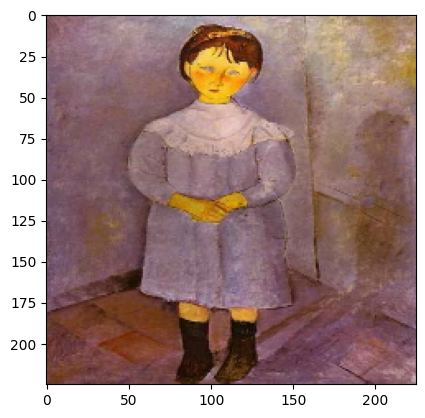


Predicted: Diego Velazquez
Actual: Diego Velazquez


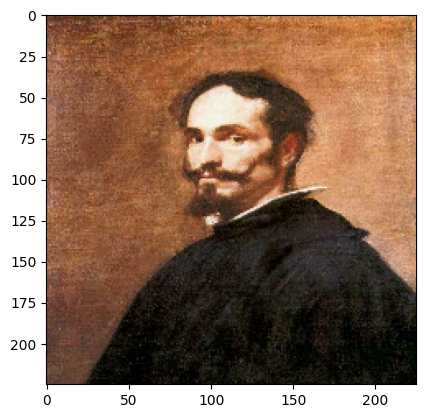


Predicted: Alfred Sisley
Actual: Alfred Sisley


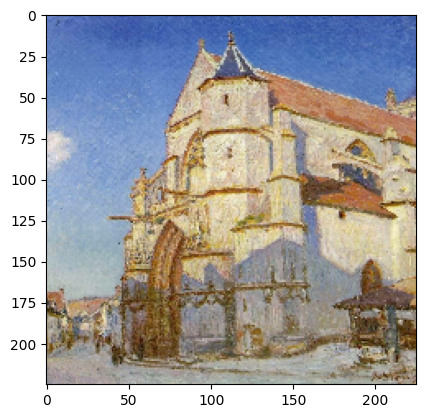


Predicted: Andrei Rublev
Actual: Andrei Rublev


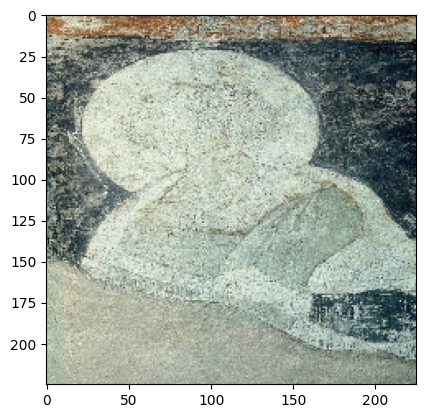


Predicted: Alfred Sisley
Actual: Claude Monet


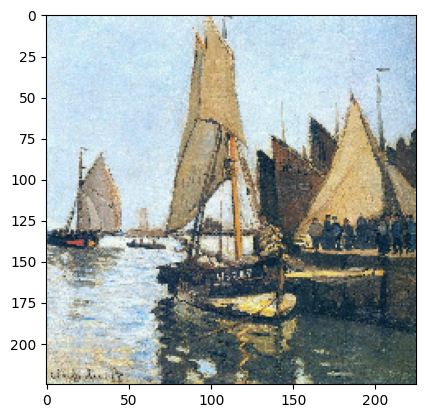


Predicted: Alfred Sisley
Actual: Claude Monet


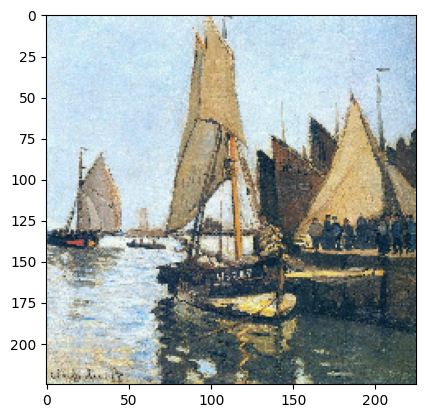

In [19]:
for batch in test_dataset.enumerate():
 test_example = batch
 break
_, test_data = test_example
test_batch_images = test_data[0]
test_batch_labels = test_data[1]

test_indexes = [0, 7, 19, 25, 27, 38]
for test_index in test_indexes:
    predicted_artist_index = np.argmax(test_batch_labels[predicted_labels[test_index]])
    actual_artist_index = np.argmax(test_batch_labels[actual_labels[test_index]])
    print(f"Predicted: {class_names[predicted_artist_index].replace('_', ' ')}")
    print(f"Actual: {class_names[actual_artist_index].replace('_', ' ')}")
    image = tf.keras.utils.array_to_img(test_batch_images[actual_labels[test_index]])
    plt.imshow(image)
    plt.show()
    print()

Завдання 2. Провести тестування отриманої моделі на незалежних 
даних

1/1 [==============================] - 0s 482ms/step
Predicted: Vincent van Gogh
Actual : Vincent van Gogh


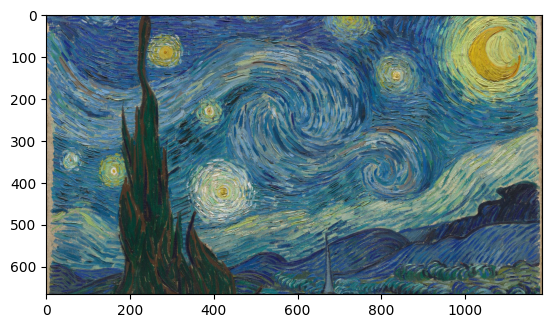

1/1 [==============================] - 1s 542ms/step
Predicted: Diego Velazquez
Actual : Carravagio


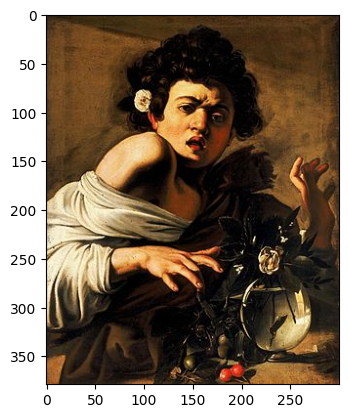

1/1 [==============================] - 0s 406ms/step
Predicted: Vincent van Gogh
Actual : Paul Cezanne


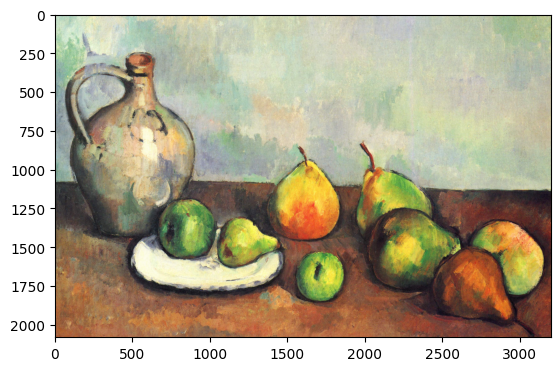

1/1 [==============================] - 0s 394ms/step
Predicted: Amedeo Modigliani
Actual : Amedeo Modigliani


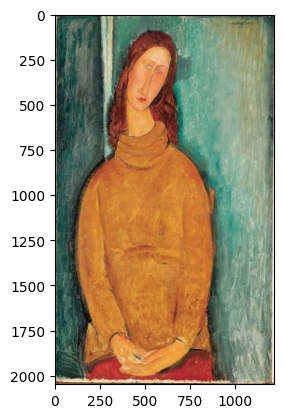

1/1 [==============================] - 0s 362ms/step
Predicted: Diego Velazquez
Actual : Diego Velazquez


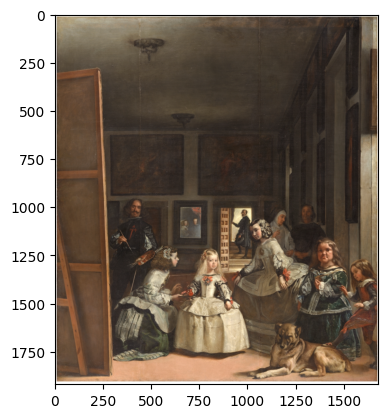

In [88]:
img_paths = ['own_test_images/gogh.jpg', 'own_test_images/carravagio.jpg', 'own_test_images/cezanne.jpg', 'own_test_images/modigliani.jpg', 'own_test_images/velazquez.jpg']
actual_labels = ['Vincent van Gogh', 'Carravagio', 'Paul Cezanne', 'Amedeo Modigliani', 'Diego Velazquez']
img_width, img_height = 225, 225
for i in range(len(img_paths)):
    img = tf.keras.preprocessing.image.load_img(img_paths[i], target_size = (img_width, img_height))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    predictions = model.predict(img)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_index]
    print(f"Predicted: {predicted_class.replace('_', ' ')}")
    print(f"Actual : {actual_labels[i]}")
    image = mpimg.imread(img_paths[i])
    plt.imshow(image)
    plt.show()